In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata


View of AnnData object with n_obs × n_vars = 1029 × 25797

In [2]:
#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


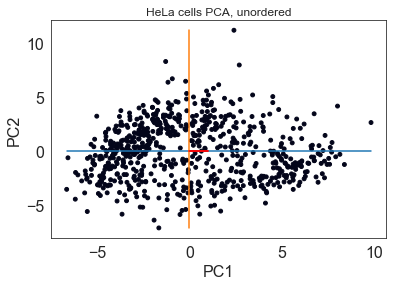

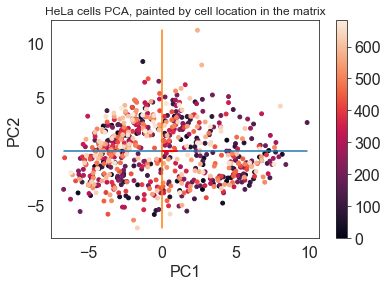

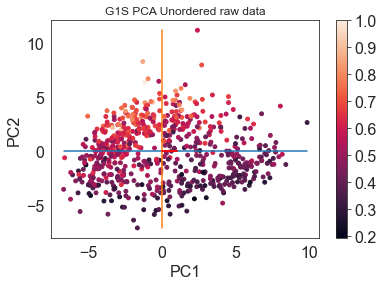

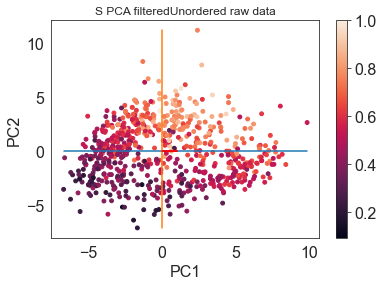

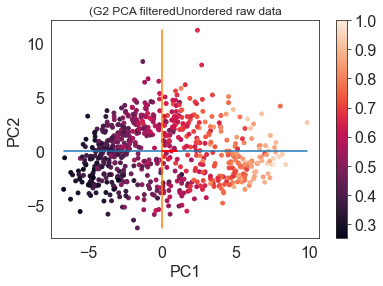

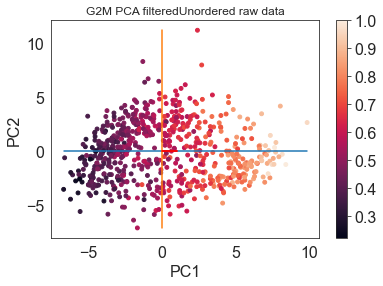

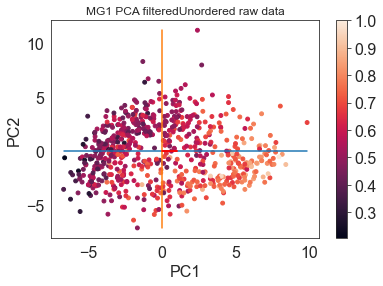

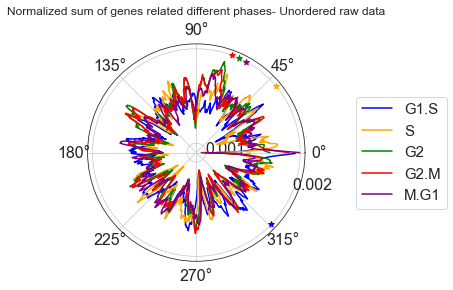

Circular mean and variance, G1S(-0.7650510202941213, 0.9923517540503247)
Circular mean and variance, S(0.6968362087722547, 0.980995789283496)
Circular mean and variance, G2(1.1438392837820615, 0.9713748004747877)
Circular mean and variance, G2M(1.2202165191700893, 0.9755857224858081)
Circular mean and variance, MG1(1.0708413965163015, 0.987100845570601)


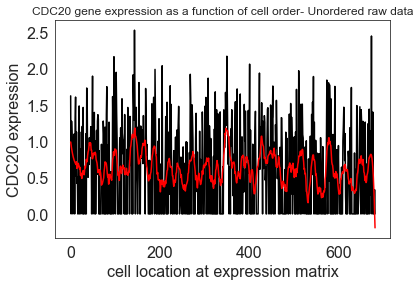

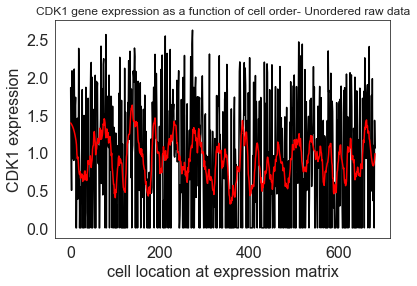

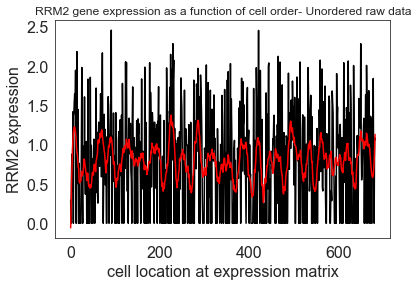

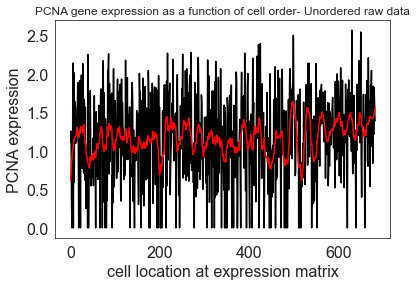

Mean AUC-ROC: 0.36920299999999995


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)
ranged_pca_2d(adata.X,color=np.zeros(adata.X.shape[0]),title=("HeLa cells PCA, unordered"),dis_colorbar=True)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 1.1857516197250117e-22
Iteration number: 25 function value= 561.3080801062048
Iteration number: 50 function value= 561.9626467706495
Iteration number: 75 function value= 572.3821051938237
Iteration number: 100 function value= 576.0043954981911
Iteration number: 125 function value= 576.0333100774249
Iteration number: 150 function value= 580.8666930645315
Iteration number: 175 function value= 579.9233981240048
Iteration number: 200 function value= 587.9227261970082
Iteration number: 225 function value= 588.9930853549031


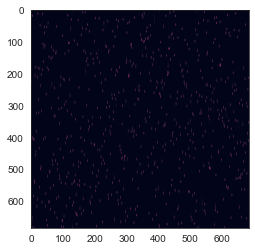

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=6000)
plt.imshow(E_sga)
plt.show()

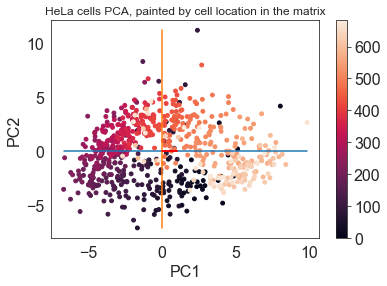

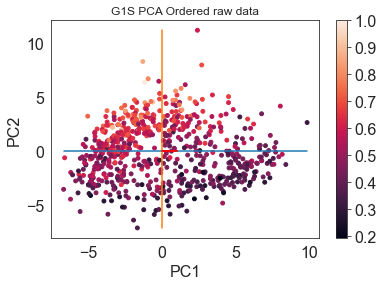

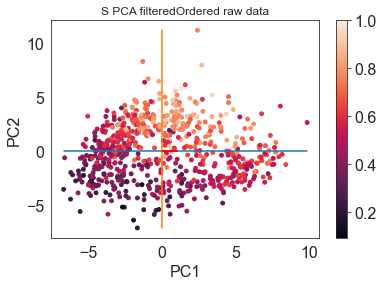

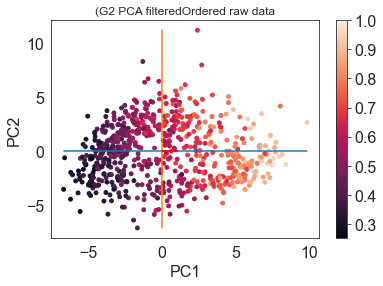

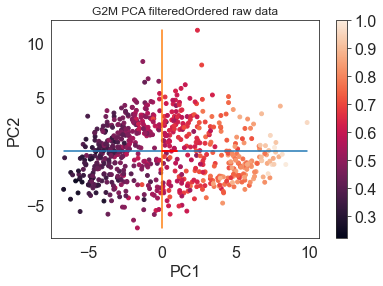

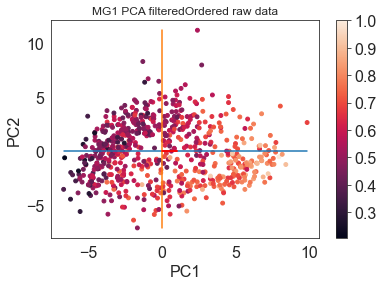

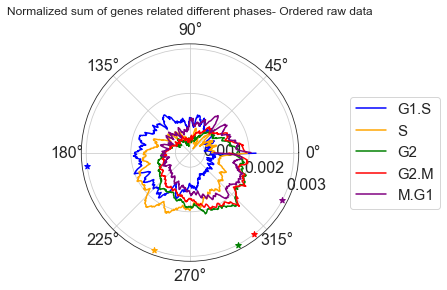

Circular mean and variance, G1S(-3.0133408538332467, 0.8908033244682135)
Circular mean and variance, S(-1.9239327799967971, 0.8268251247235493)
Circular mean and variance, G2(-1.0887030712102532, 0.8089038609681927)
Circular mean and variance, G2M(-0.9065324300181183, 0.8267363138290331)
Circular mean and variance, MG1(-0.4788267918547505, 0.8899310643092021)


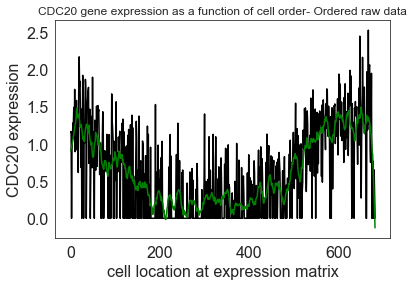

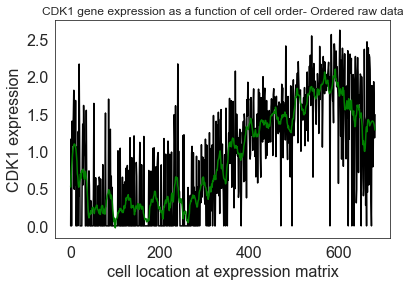

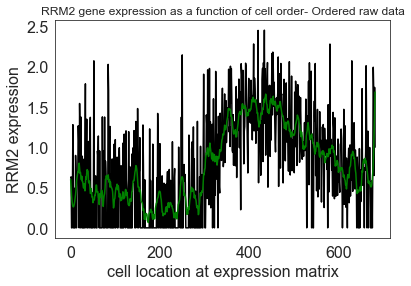

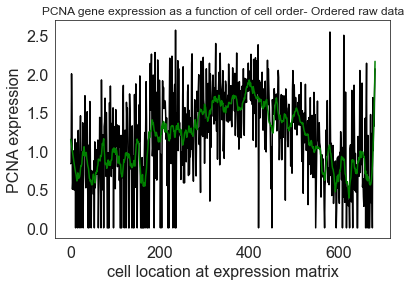

Mean AUC-ROC: 0.8036695


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 510.7101177831076
Iteration number: 26 function value: 1105.789477409815
Iteration number: 51 function value: 2585.618675780129
Iteration number: 76 function value: 3387.723059488927
norm change 447.76978353446935


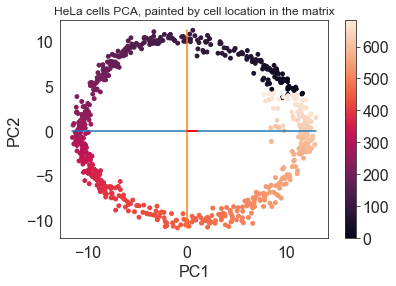

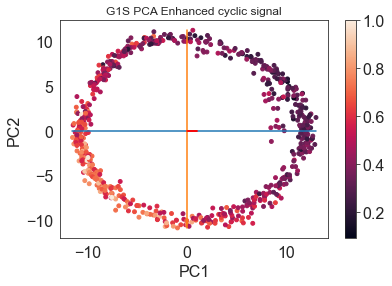

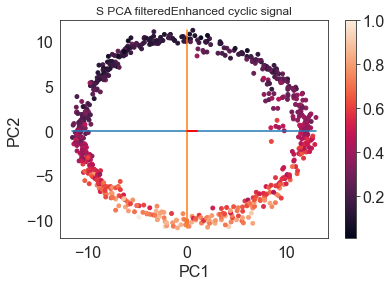

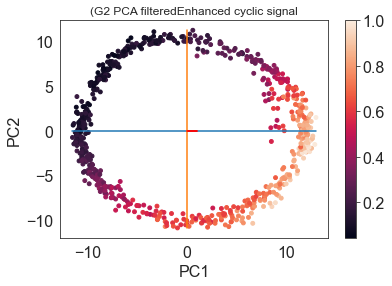

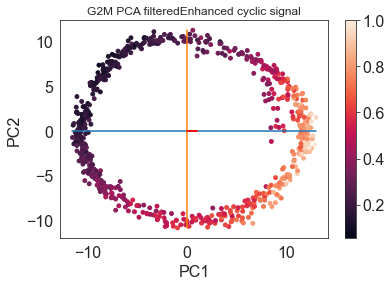

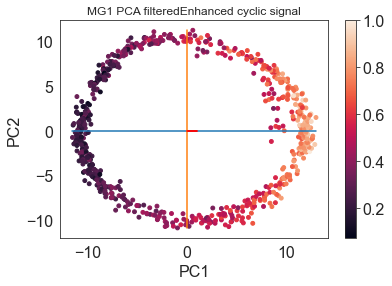

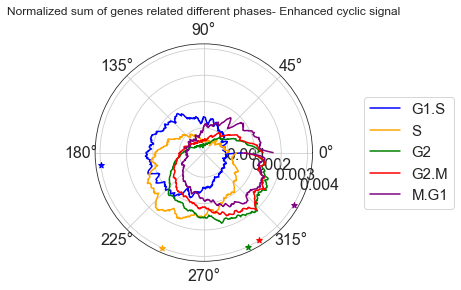

Circular mean and variance, G1S(-3.025762390695939, 0.7890139438628466)
Circular mean and variance, S(-1.9807999449300848, 0.6448380135993883)
Circular mean and variance, G2(-1.1358644240776612, 0.5591715441570039)
Circular mean and variance, G2M(-1.0081267587778993, 0.6403385858544178)
Circular mean and variance, MG1(-0.5262835013956108, 0.6944279173523535)


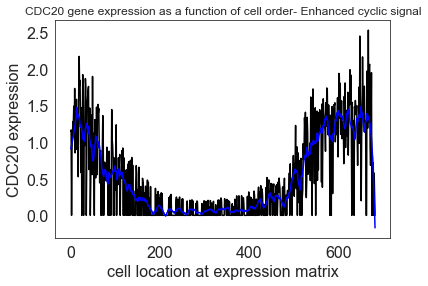

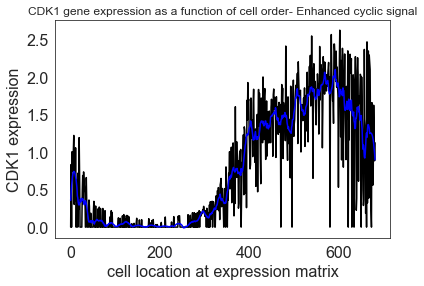

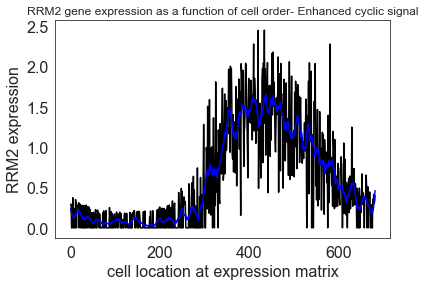

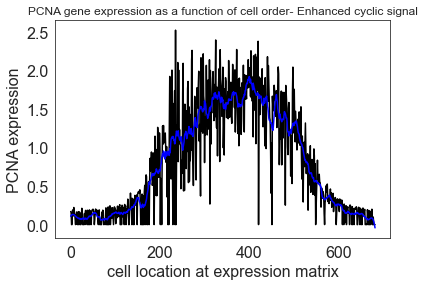

Mean AUC-ROC: 0.8326359999999999


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=100)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 104.99053345951774 gradient :: 2.474518553774737
50th Iteration    Loss :: 50.606240375888916 gradient :: 1.2581418881494588
75th Iteration    Loss :: 33.579103995793616 gradient :: 0.8368383913588553
100th Iteration    Loss :: 25.512381352248426 gradient :: 0.6238644265293201
125th Iteration    Loss :: 20.852496234083176 gradient :: 0.4964390758093131
150th Iteration    Loss :: 17.828694923551204 gradient :: 0.4217343754260909
175th Iteration    Loss :: 15.810308033115572 gradient :: 0.3747137073590164
200th Iteration    Loss :: 14.288922780896062 gradient :: 0.3492386215262998
225th Iteration    Loss :: 13.103066362827615 gradient :: 0.30159443348315546
250th Iteration    Loss :: 12.147185107686852 gradient :: 0.2621199887353373
275th Iteration    Loss :: 11.344283806082569 gradient :: 0.24296516670371485
300th Iteration    Loss :: 10.664859107138216 gradient :: 0.2308512972634956
325th Iteration    Loss :: 10.082479477097266 gradient :: 0

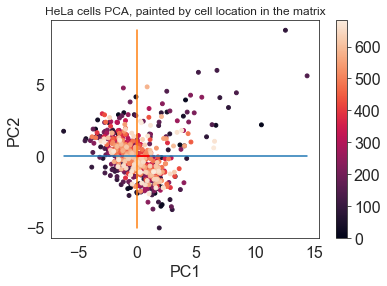

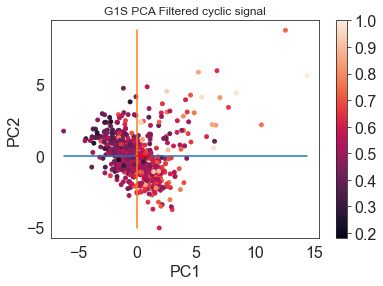

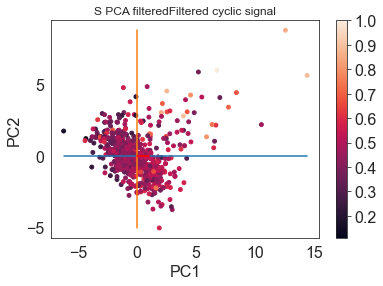

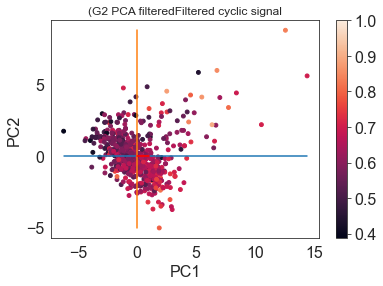

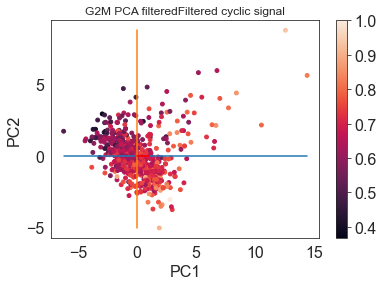

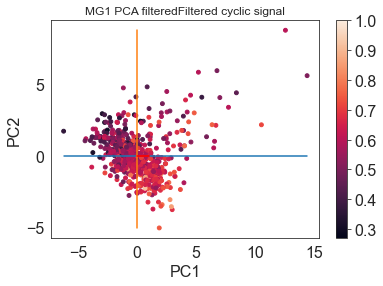

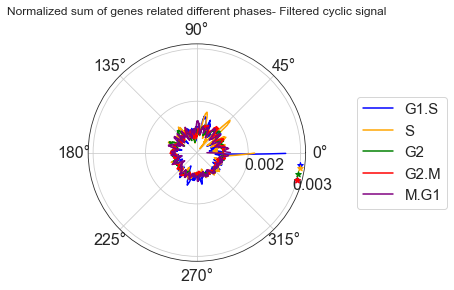

Circular mean and variance, G1S(-0.12078234393008319, 0.9899428861157531)
Circular mean and variance, S(-0.1494705479010803, 0.9893363791969226)
Circular mean and variance, G2(-0.21048582608932678, 0.9890875334305915)
Circular mean and variance, G2M(-0.26571220120198286, 0.9887509714434921)
Circular mean and variance, MG1(-0.2654701933885589, 0.9888014543889972)


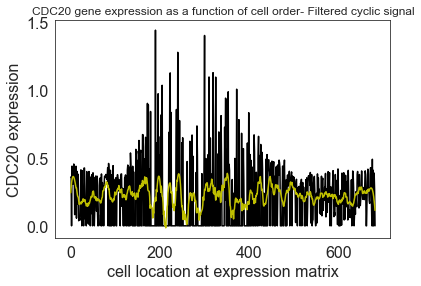

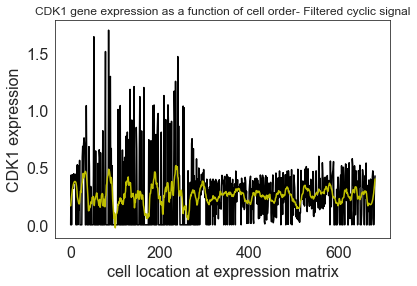

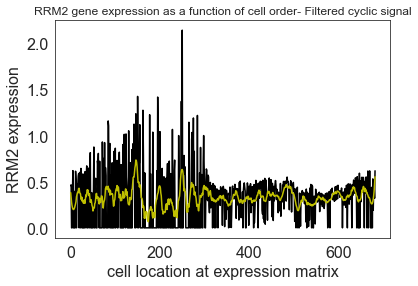

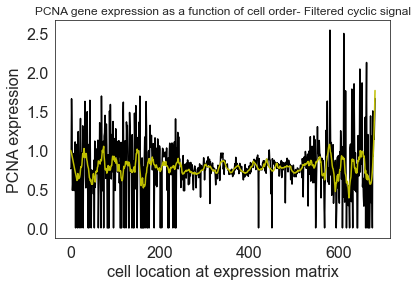

Mean AUC-ROC: 0.1867805


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 885.04767
Iteration number: 1 function value: 510.71122112426076
norm change 48.308803204431946


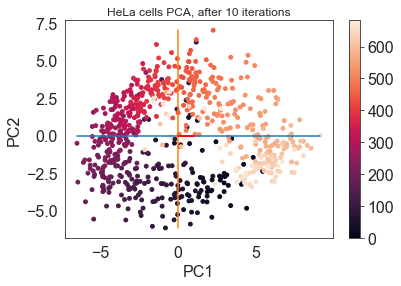

Iteration number: 1 function value: 510.71902327881105
norm change 109.27367852863041


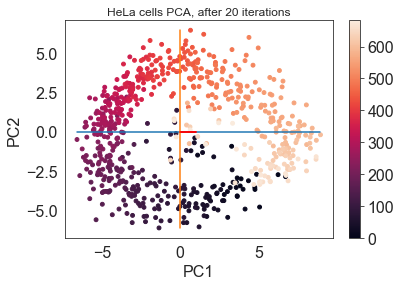

Iteration number: 1 function value: 510.71136575440926
Iteration number: 26 function value: 1105.235294165859
norm change 192.13743840972054


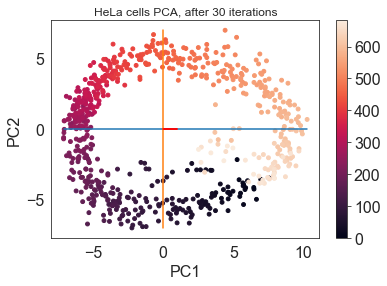

Iteration number: 1 function value: 510.72693300836625
Iteration number: 26 function value: 1105.669495653187
norm change 261.1894546252875


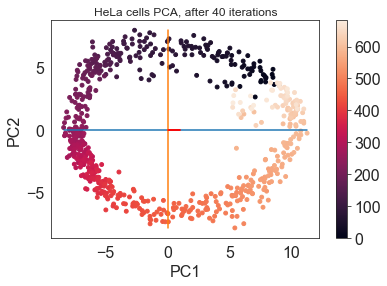

Iteration number: 1 function value: 510.6939132911242
Iteration number: 26 function value: 1105.221890261915
norm change 311.5349922258434


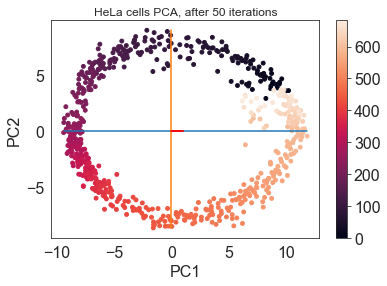

Iteration number: 1 function value: 510.69751634192033
Iteration number: 26 function value: 1105.7574950601547
Iteration number: 51 function value: 2586.1405661697104
norm change 347.6664308727456


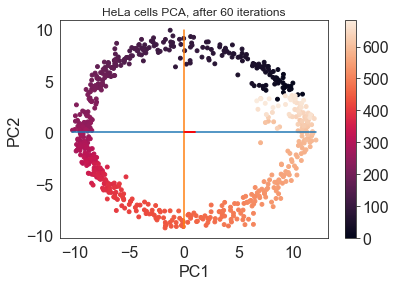

Iteration number: 1 function value: 510.7251110537563
Iteration number: 26 function value: 1105.964320764175
Iteration number: 51 function value: 2585.9070532624937
norm change 377.6982961489049


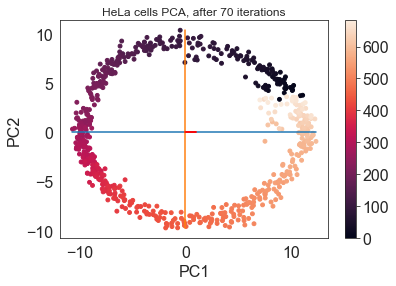

Iteration number: 1 function value: 510.70947040522645
Iteration number: 26 function value: 1105.988219574651
Iteration number: 51 function value: 2586.4506608512606
Iteration number: 76 function value: 3387.8499667920482
norm change 404.4592762122427


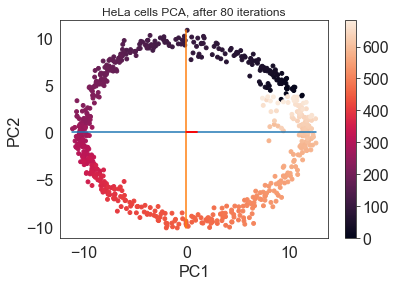

Iteration number: 1 function value: 510.7108579227474
Iteration number: 26 function value: 1105.7981518589852
Iteration number: 51 function value: 2586.2768573775193
Iteration number: 76 function value: 3387.923392631231
norm change 427.5863659222846


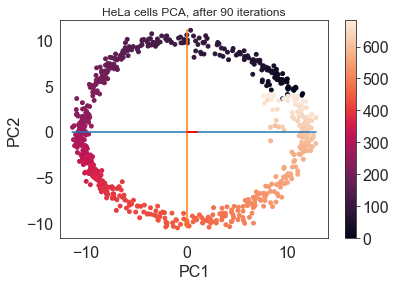

Iteration number: 1 function value: 510.69932126086337
Iteration number: 26 function value: 1105.6818001997776
Iteration number: 51 function value: 2586.085060516905
Iteration number: 76 function value: 3387.5320479752177
norm change 447.80596635717535


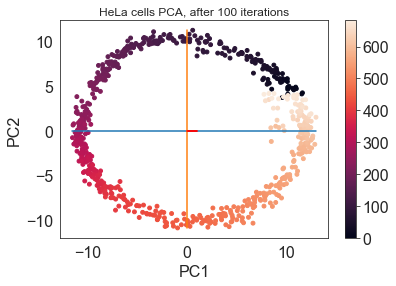

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    adata = copy.deepcopy(orig_adata.copy())
    F = enhancement_cyclic(adata.X,regu=0.05,iterNum=(10*(i+1)))
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

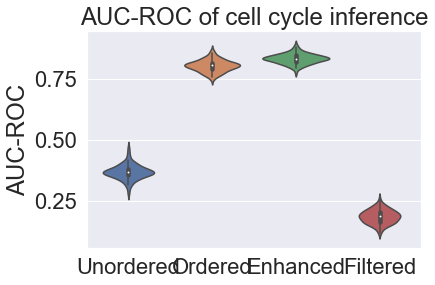

In [9]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})
sns.set_style("whitegrid")

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")

sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()

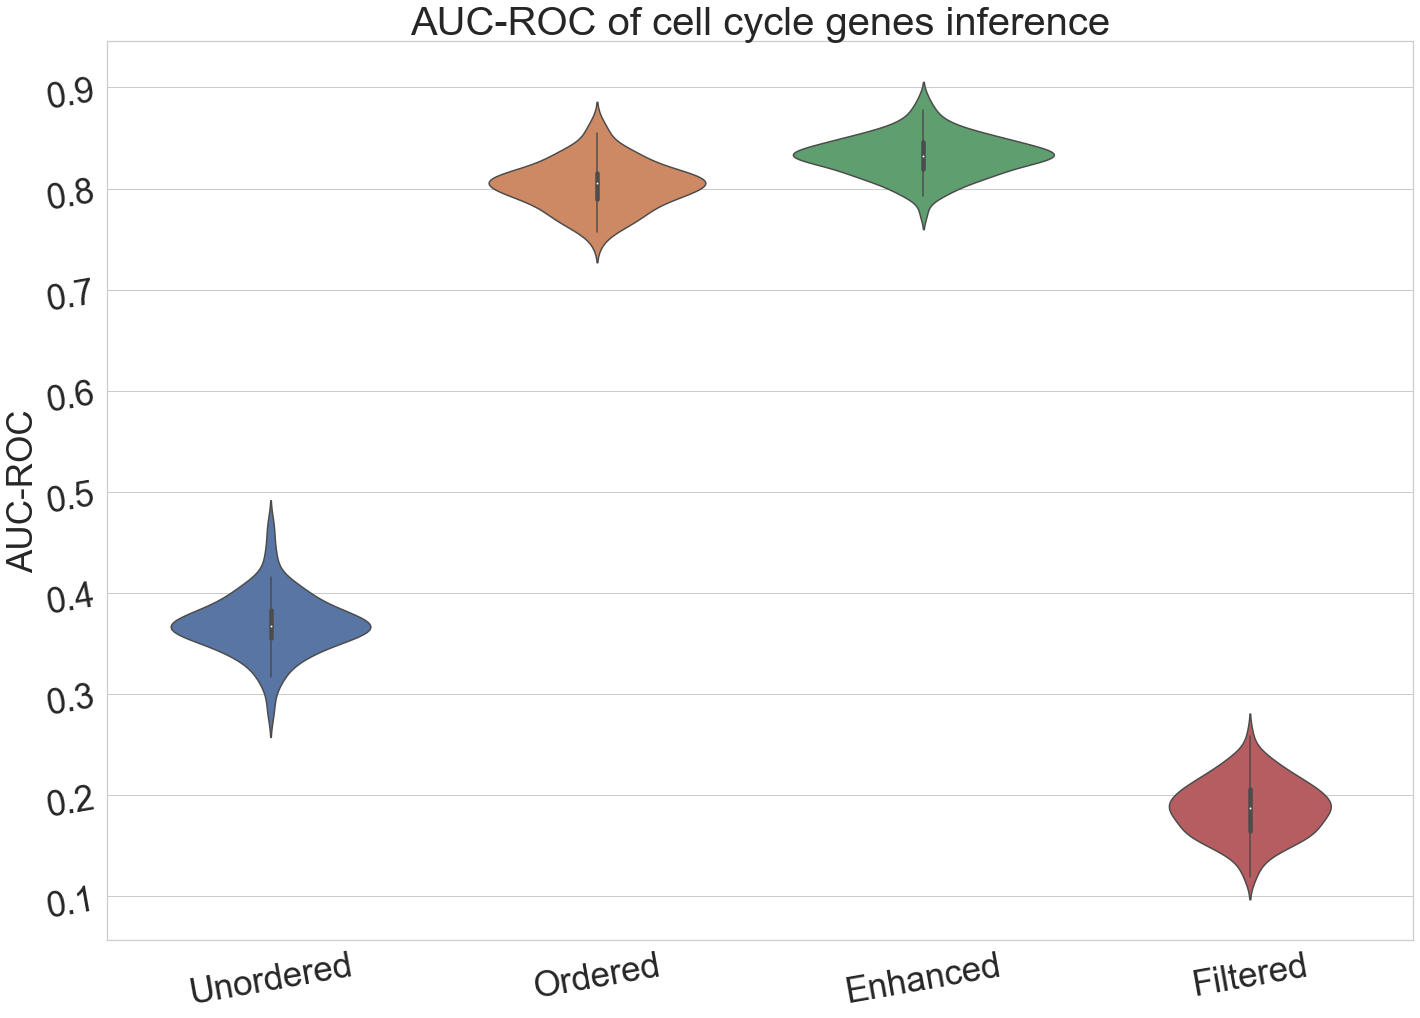

In [11]:
sns.set_style("whitegrid")

b = sns.violinplot(data=data)
#b.axes.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(23.4,16.54)})
b.axes.set_title("AUC-ROC of cell cycle genes inference",fontsize=40)
b.set_ylabel("AUC-ROC",fontsize=35)
b.tick_params(rotation=10,labelsize=35)
#b.axes.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


sns.set(rc={'figure.figsize':(23.4,16.54)})
#plt.title("MSE between simulated cyclic signal and output of enhancement methods" ,fontsize='24')

sns.set_style("whitegrid")

plt.show()